## Introduction
Structured Query Language (SQL) is a very important tool for both Data Analysis and Business Analysis. This tool enables the user to be able to modify and retrieve relevant data from complex databases. Within this notebook, I will use basic and advanced SQL queries to retrieve information from the "Employees" dataset.

[Employees Dataset](https://www.kaggle.com/ptxmalca/employees-dataset)

After the data is correctly retrieved, in order to answer specific business questions, I will proceed to visualize the insight with the visualization tool Tableau. Tableau is a very powerful software for business intelligence which allows the user to interpret large datasets into a more digestible representation.

## The Task
In this notebook, four tasks will be solved from the employees database. I will be showing a query to retrieve the appropriate data alongside a proper visualization using a Tableau dashboard at the end of the notebook. Additional tasks will be written at the end of the visualization in order to showcase other advanced SQL knowledge.

### Task 1
Create a visualization that provides a breakdown between the male and female employees working in the company each year, starting from 1990.

In [ ]:
## Query

SELECT
	YEAR(de.from_date) AS calendar_year,
    e.gender,
    COUNT(DISTINCT e.emp_no) AS employee_count
FROM
	t_employees e
		JOIN
	t_dept_emp de ON e.emp_no = de.emp_no
GROUP BY calendar_year, gender
HAVING calendar_year >= 1990
ORDER BY calendar_year;

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 5)

### Task 2
Compare the number of male managers to the number of female managers from different departments for each year, starting from 1990.

In [ ]:
## Query

SELECT
	d.dept_name,
	ee.gender,
	dm.emp_no,
	dm.from_date,
	dm.to_date,
	e.calendar_year,
	CASE
		WHEN YEAR(dm.to_date) >= e.calendar_year AND YEAR(dm.from_date) <= e.calendar_year THEN 1
        ELSE 0
	END AS active
FROM
	(SELECT
		YEAR(hire_date) AS calendar_year
	FROM
		t_employees
	GROUP BY calendar_year) e
	CROSS JOIN
	t_dept_manager dm
	JOIN
	t_departments d ON dm.dept_no = d.dept_no
	JOIN
	t_employees ee ON dm.emp_no = ee.emp_no
ORDER BY emp_no, calendar_year;

### Task 3
Compare the average salary of female versus male employees in the entire company until year 2002, and add a filter allowing you to see that per each department.

In [ ]:
## Query

SELECT
	e.gender,
    d.dept_name,
    ROUND(AVG(s.salary),2) AS avg_salary,
    YEAR(s.from_date) AS calendar_year
FROM
	t_employees e
		JOIN
	t_salaries s ON e.emp_no = s.emp_no
		JOIN
	t_dept_emp de ON e.emp_no = de.emp_no
		JOIN
	t_departments d ON de.dept_no = d.dept_no
GROUP BY e.gender, d.dept_no, calendar_year
HAVING calendar_year <= 2002
ORDER BY d.dept_no, e.gender, calendar_year;


### Task 4
Create an SQL stored procedure that will allow you to obtain the average male and female salary per department within a certain salary range. Let this range be defined by two values the user can insert when calling the procedure. Analyse the salaries between the range of 50,000 and 90,000.

In [ ]:
## Query

DROP PROCEDURE IF EXISTS dept_salary_gender;

DELIMITER $$
CREATE PROCEDURE dept_salary_gender (IN p_lower_bracket FLOAT, IN p_higher_bracket FLOAT)
BEGIN
	SELECT
		d.dept_name,
		e.gender,
        ROUND(AVG(s.salary),2) AS avg_salary
	FROM
		t_salaries s
			JOIN
		t_employees e ON s.emp_no = e.emp_no
			JOIN
		t_dept_emp de ON de.emp_no = s.emp_no
			JOIN
		t_departments d ON d.dept_no = de.dept_no
WHERE s.salary BETWEEN p_lower_bracket AND p_higher_bracket
GROUP BY de.dept_no, e.gender
ORDER BY de.dept_no, e.gender;
END$$
DELIMITER ;

call employees_mod.dept_salary_gender(50000, 90000);

## Visualization in Tableau

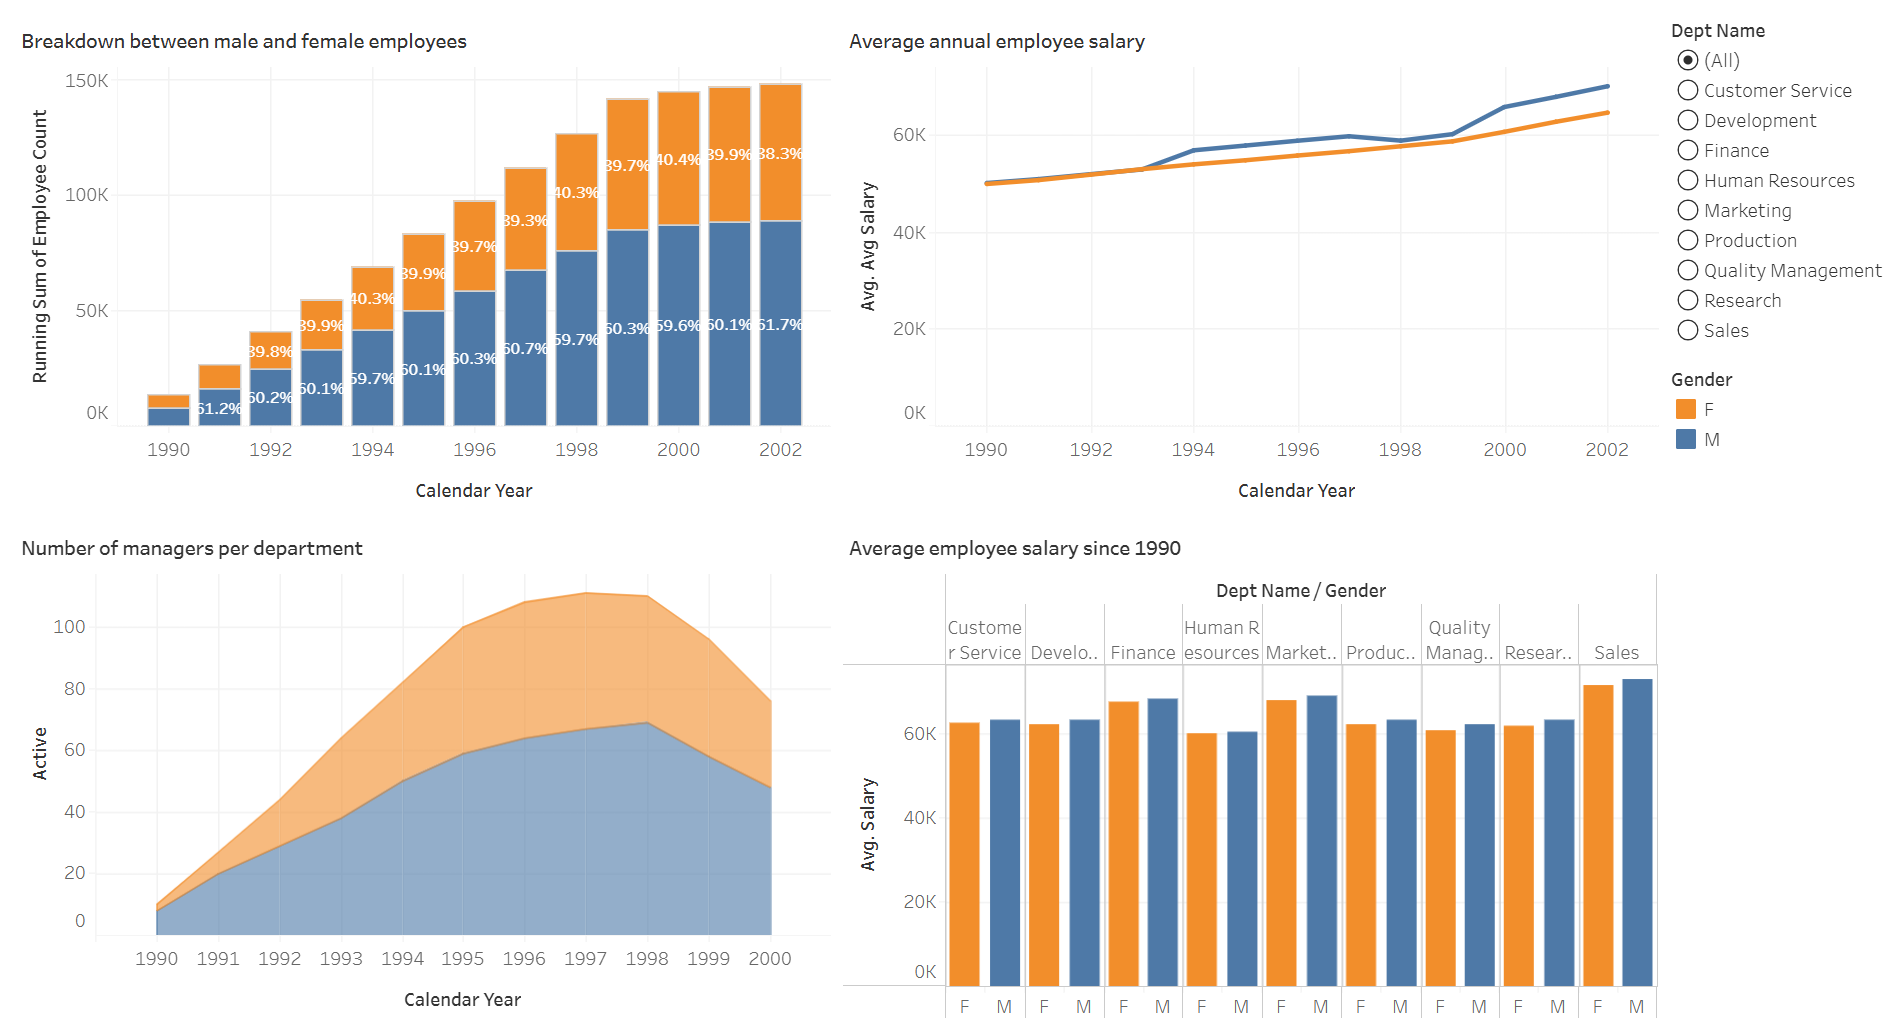

## Additional Tasks

### Trigger Task
Create a trigger that checks if the hire date of an employee is higher than the current date. If true, set the hire date to equal the current date. Format the output appropriately (YY-mm-dd).

In [ ]:
DELIMITER $$
CREATE TRIGGER hire_date_trigger
BEFORE INSERT ON employees
FOR EACH ROW
BEGIN
	DECLARE today DATE;
    SELECT DATE_FORMAT(SYSDATE(), '%y-%m-%d') INTO today;

	IF NEW.hire_date > today THEN
		SET NEW.hire_date = today;
	END IF;
END $$
DELIMITER ;

INSERT employees VALUES ('999904', '1970-01-31', 'John', 'Johnson', 'M', '2025-01-01');

SELECT
    *
FROM
    employees
ORDER BY emp_no DESC;

### Function Task
Define a function that retrieves the highest or the lowest contract salary value of an employee. Evaluate if its value is 'min' or 'max' and based on that retrieve either the lowest or the highest salary, respectively. If the inserted value is any string value different from ‘min’ or ‘max’, let the function return the difference between the highest and the lowest salary of that employee.

Apply this function to employee number 11356.

In [ ]:
DELIMITER $$
CREATE FUNCTION f_select_salary(p_emp_no INT, p_value VARCHAR(3)) RETURNS DECIMAL(10,2)
DETERMINISTIC NO SQL READS SQL DATA
BEGIN
	DECLARE v_salary DECIMAL(10,2);

	SELECT
		CASE
			WHEN p_value = 'min' THEN MIN(salary)
            WHEN p_value = 'max' THEN MAX(salary)
            ELSE MAX(salary) - MIN(salary)
		END AS salary
	INTO v_salary
	FROM
		salaries
    WHERE
		p_emp_no = emp_no;
RETURN v_salary;
END$$
DELIMITER ;

SELECT f_select_salary(11356,'min');
SELECT f_select_salary(11356,'max');
SELECT f_select_salary(11356,'abc');